<a href="https://colab.research.google.com/github/hafizhahnajwa20/SISTEM-REKOMENDASI-ABON-UMI/blob/main/Algoritma_XGBoost_(Extreme_Gradient_Boosting).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Collaborative Filtering dan Tren Analisis Penjualan (Prediksi dan Rekomendasi) menggunakan Algoritma XGBoost (Extreme Gradient Boosting)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data berhasil dimuat. Kolom: ['Tanggal', 'Nama Abon', 'Jenis Abon', 'Berat Kemasan', 'Jumlah', 'Harga Satuan', 'Total']
      Tanggal  Nama Abon Jenis Abon Berat Kemasan  Jumlah Harga Satuan  \
0  13/01/2025  Abon Ikan      Pedas      100 gram      19  Rp22.000,00   
1  13/01/2025  Abon Ikan      Manis      200 gram       3  Rp38.000,00   
2  13/01/2025  Abon Ayam      Pedas      200 gram       7  Rp43.000,00   
3  13/01/2025  Abon Ayam      Pedas      100 gram       2  Rp27.000,00   
4  13/01/2025  Abon Ikan      Pedas      500 gram       2  Rp80.000,00   

          Total  
0  Rp418.000,00  
1  Rp114.000,00  
2  Rp301.000,00  
3   Rp54.000,00  
4  Rp160.000,00   

Data setelah di-preprocess (diubah menjadi angka):
     Tanggal  Nama Barang Jenis Abon Berat Kemasan  Jumlah Barang  \
0 2025-01-13            1      Pedas      100 gram             19   
1 202

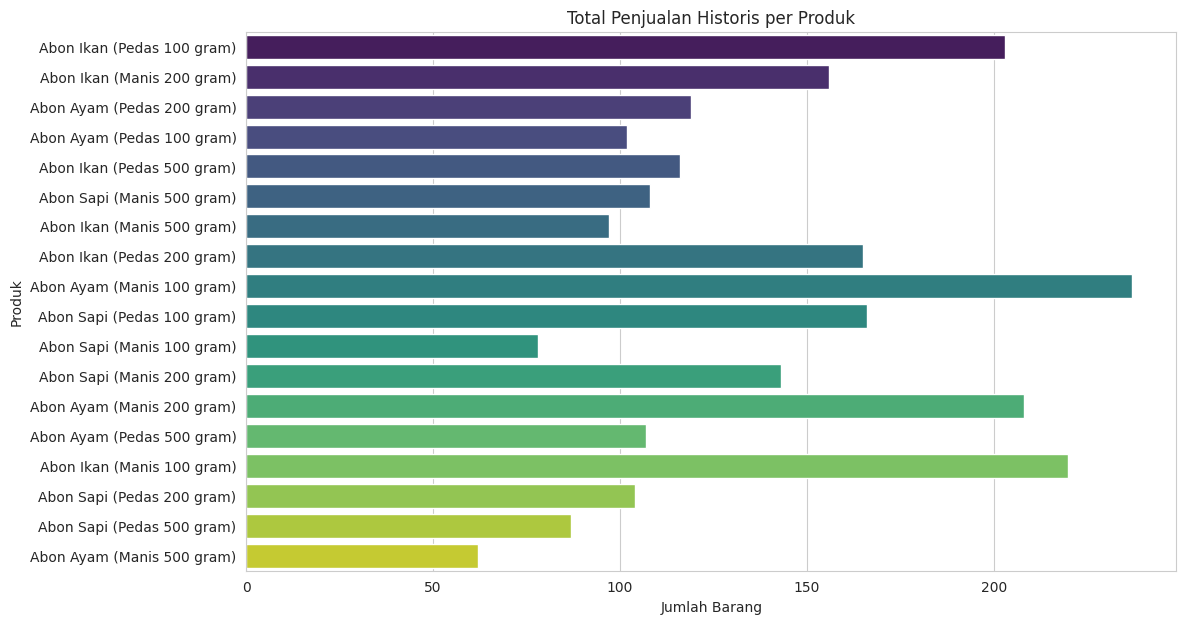



🚀 Memulai pelatihan model XGBoost...
Pelatihan model selesai.
Evaluasi Model - Root Mean Squared Error (RMSE): 5.27
Artinya, rata-rata kesalahan prediksi model adalah sekitar 5 unit barang.


✅ HASIL REKOMENDASI & TREN PENJUALAN

Prediksi Total Penjualan per Produk untuk Bulan 7/2025:
   Nama Barang         Kemasan  Prediksi_Jumlah
6    Abon Ikan  Manis 100 gram             81.0
0    Abon Ayam  Manis 100 gram             79.0
15   Abon Sapi  Pedas 100 gram             51.0
12   Abon Sapi  Manis 100 gram             35.0
10   Abon Ikan  Pedas 200 gram             33.0
5    Abon Ayam  Pedas 500 gram             31.0
4    Abon Ayam  Pedas 200 gram             30.0
9    Abon Ikan  Pedas 100 gram             30.0
1    Abon Ayam  Manis 200 gram             28.0
11   Abon Ikan  Pedas 500 gram             25.0
13   Abon Sapi  Manis 200 gram             25.0
14   Abon Sapi  Manis 500 gram             25.0
16   Abon Sapi  Pedas 200 gram             24.0
8    Abon Ikan  Manis 500 gram          

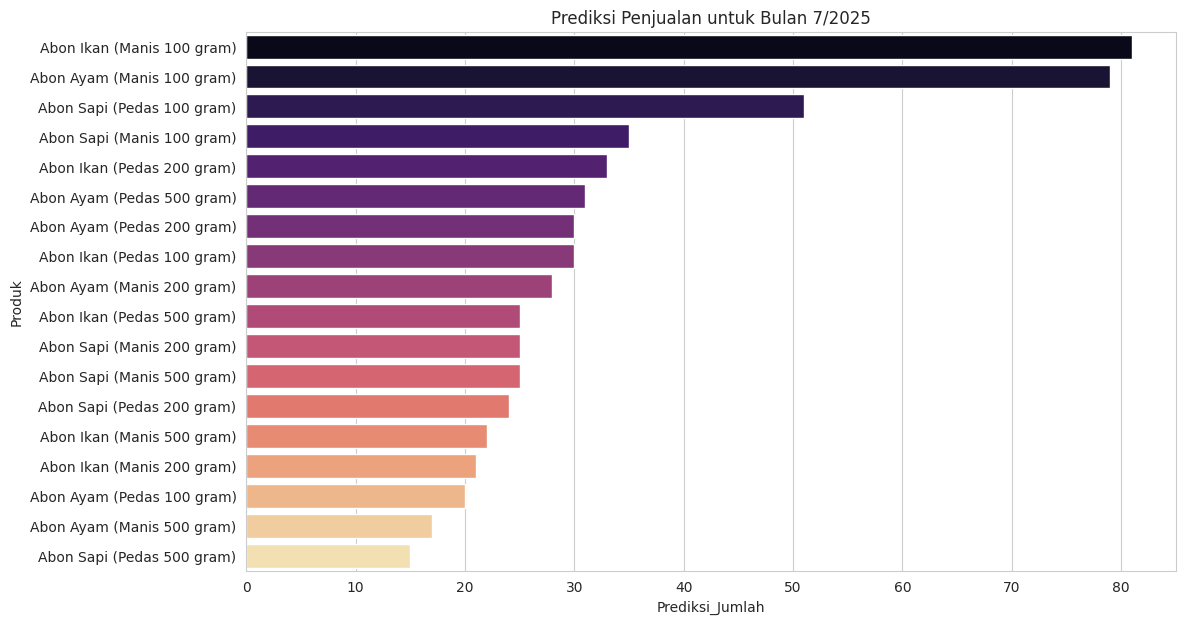

💡 Rekomendasi Utama:
Berdasarkan model prediksi, produk yang berpotensi **paling laku** di Bulan 7/2025 adalah **Abon Ikan** dengan kemasan **Manis 100 gram**.
Toko 'Abon Ummi' disarankan untuk mempersiapkan stok lebih untuk produk tersebut.


In [12]:
# --- 0. Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# Path ke file CSV
file_path = '/content/drive/MyDrive/abon.csv'

# --- 1. Import Library ---
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# --- 2. Load Data ---
df = pd.read_csv(file_path)
print("✅ Data berhasil dimuat. Kolom:", df.columns.tolist())
print(df.head(), "\n", "="*50, "\n")

# --- 3. Rename & Tambahkan Kolom ---
df.rename(columns={'Nama Abon':'Nama Barang','Jumlah':'Jumlah Barang'}, inplace=True)
df['Kemasan'] = df['Jenis Abon'].astype(str) + ' ' + df['Berat Kemasan'].astype(str)

# Tambahkan kolom Alamat dummy (jika tidak ada di CSV)
if 'Alamat' not in df.columns:
    df['Alamat'] = np.random.choice(['Cappa Galung','Ujung Sabbang','Bacukiki'], len(df))

# Tambahkan kolom Pembeli dummy (jika tidak ada)
df['Pembeli'] = np.random.choice(['Ummi','Rina','Ali','Budi'], len(df))

# Konversi harga satuan dari format "Rp22.000,00" ke integer
df['Harga Satuan'] = df['Harga Satuan'].replace('[Rp,.]', '', regex=True).astype(int)

# Hitung total harga
df['Total'] = df['Jumlah Barang'] * df['Harga Satuan']

# Konversi Tanggal
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y', errors='coerce')
df['Bulan'] = df['Tanggal'].dt.month
df['Tahun'] = df['Tanggal'].dt.year

# --- 4. Encoding Kolom Kategorikal ---
encoders = {}
for col in ['Pembeli', 'Alamat', 'Nama Barang', 'Kemasan']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

print("Data setelah di-preprocess (diubah menjadi angka):")
print(df.head(), "\n", "="*50, "\n")

# --- 5. Visualisasi Historis ---
df_viz = df.copy()
for col, le in encoders.items():
    df_viz[col] = le.inverse_transform(df[col])
df_viz['Produk'] = df_viz['Nama Barang'] + ' (' + df_viz['Kemasan'] + ')'

plt.figure(figsize=(12,7))
sns.barplot(data=df_viz, y='Produk', x='Jumlah Barang', estimator=sum, errorbar=None, palette='viridis', hue='Produk', legend=False)
plt.title('Total Penjualan Historis per Produk')
plt.show()
print("\n" + "="*50 + "\n")

# --- 6. Model XGBoost ---
X = df[['Pembeli','Alamat','Nama Barang','Kemasan','Bulan','Tahun']]
y = df['Jumlah Barang']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

print("🚀 Memulai pelatihan model XGBoost...")
model.fit(X_train, y_train)
print("Pelatihan model selesai.")

rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print(f"Evaluasi Model - Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Artinya, rata-rata kesalahan prediksi model adalah sekitar {rmse:.0f} unit barang.\n")
print("="*50, "\n")

# --- 7. Prediksi untuk Juli 2025 ---
future_month, future_year = 7, 2025
future_scenarios = list(itertools.product(df['Pembeli'].unique(), df['Alamat'].unique(), df['Nama Barang'].unique(), df['Kemasan'].unique()))
future_df = pd.DataFrame(future_scenarios, columns=['Pembeli','Alamat','Nama Barang','Kemasan'])
future_df['Bulan'], future_df['Tahun'] = future_month, future_year

# Prediksi
preds = model.predict(future_df)
future_df['Prediksi_Jumlah'] = np.clip(np.round(preds), 0, None)

# Decode ke nama asli
decoded_future = future_df.copy()
for col, le in encoders.items():
    decoded_future[col] = le.inverse_transform(future_df[col])

# Agregasi prediksi
trend = decoded_future.groupby(['Nama Barang','Kemasan'])['Prediksi_Jumlah'].sum().reset_index()
trend_sorted = trend.sort_values(by='Prediksi_Jumlah', ascending=False)

print("✅ HASIL REKOMENDASI & TREN PENJUALAN\n")
print(f"Prediksi Total Penjualan per Produk untuk Bulan {future_month}/{future_year}:")
print(trend_sorted, "\n", "="*50, "\n")

# --- 8. Visualisasi Prediksi ---
trend_sorted['Produk'] = trend_sorted['Nama Barang'] + ' (' + trend_sorted['Kemasan'] + ')'
plt.figure(figsize=(12,7))
sns.barplot(data=trend_sorted, y='Produk', x='Prediksi_Jumlah', palette='magma', hue='Produk', legend=False)
plt.title(f'Prediksi Penjualan untuk Bulan {future_month}/{future_year}')
plt.show()

# --- 9. Rekomendasi Produk ---
top = trend_sorted.iloc[0]
print("💡 Rekomendasi Utama:")
print(f"Berdasarkan model prediksi, produk yang berpotensi **paling laku** di Bulan {future_month}/{future_year} adalah **{top['Nama Barang']}** dengan kemasan **{top['Kemasan']}**.")
print("Toko 'Abon Ummi' disarankan untuk mempersiapkan stok lebih untuk produk tersebut.")

